[gluon](http://zh.gluon.ai/chapter_computer-vision/ssd.html)   [gluon](http://zh.gluon.ai/chapter_computer-vision/anchor.html)    
这是一个没有预训练模型的SSD实现，也是因为没有预训练模型，只能用来处理一些比较简单的数据集。     

如下是SSD的框架示意图   
![SSD](images/ssd.svg)   

输入图像经过一个backbone网络提取特征，然后进行若干次下采样，每个下采样层都附带一个边框预测和类别预测模块。注意和YOLOv3不同，SSD是基于backbone的输出特征图做多次下采样，这也导致SSD对小目标检测效果不好。    


# 自定义一个简单的Backbone网络

In [1]:
from mxnet import contrib, image, nd,gluon,autograd, init
from mxnet.gluon import loss as gloss, nn
import mxnet as mx

C:\Users\001\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

#这个下采样层既用在backbone中，也用在后续的检测模块中
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

#backbone
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

#完整的特征提取模块
#0： backbone
#1,2,3： 三个下采样层
#4：一个global max pool层
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk






# 定义类别预测层和边框预测层

In [3]:
#类别预测层，这里用一个卷积层实现
#其输入输出层的w/h必须一致
#输出通道数C等于(anchor个数)x(类别数+1)，这里类别不包括背景，+1就是背景类
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)


#边框预测层，也用一个卷积层实现
#输入输出的w/h必须一致
#输出通道数C等于4x(anchor个数)
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)


#不同层预测出来的类别和边框的尺寸是不一样的，下面定义了一种合并方式
#每一层输出的是shape是(batch,C,H,W),不同层的输出，只有batch是一致的，其他三个值都不一样
#下面的函数把(batch,C,H,W)转换成(batch,HxWxC)
#最后在dim=1上连接
#注意mx.nd.flatten()的功能和numpy.flatten()不同，mx.nd.flatten()会保留维度0，只合并后面的维度
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

# 定义每个层如何预测 (SSD的重点）

In [4]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X) #提取特征
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio) #获得anchor
    cls_preds = cls_predictor(Y) #预测类别 （这不是上面定义的函数，而是其具体实现，即一个卷积层）
    bbox_preds = bbox_predictor(Y) #预测边界框 （这不是上面定义的函数，而是其具体实现，即一个卷积层）
    return (Y, anchors, cls_preds, bbox_preds)

# 定义SSD模型

In [5]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        
        self.sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],[0.88, 0.961]]
        self.ratios = [[1, 2, 0.5]] * 5
        self.num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1

        self.stage_0, self.stage_1, self.stage_2, self.stage_3, self.stage_4 = nn.Sequential(),nn.Sequential(),nn.Sequential(),nn.Sequential(),nn.Sequential()
        
        self.stage_0.add(get_blk(0), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #backbone
        self.stage_1.add(get_blk(1), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第1个预测层
        self.stage_2.add(get_blk(2), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第2个预测层
        self.stage_3.add(get_blk(3), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第3个预测层
        self.stage_4.add(get_blk(4), cls_predictor(self.num_anchors, self.num_classes), bbox_predictor(self.num_anchors)) #第4个预测层 
        return
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        X,anchors[0], cls_preds[0], bbox_preds[0] = blk_forward(X, self.stage_0[0], self.sizes[0], self.ratios[0], self.stage_0[1], self.stage_0[2])
        X,anchors[1], cls_preds[1], bbox_preds[1] = blk_forward(X, self.stage_1[0], self.sizes[1], self.ratios[1], self.stage_1[1], self.stage_1[2])
        X,anchors[2], cls_preds[2], bbox_preds[2] = blk_forward(X, self.stage_2[0], self.sizes[2], self.ratios[2], self.stage_2[1], self.stage_2[2])
        X,anchors[3], cls_preds[3], bbox_preds[3] = blk_forward(X, self.stage_3[0], self.sizes[3], self.ratios[3], self.stage_3[1], self.stage_3[2])
        X,anchors[4], cls_preds[4], bbox_preds[4] = blk_forward(X, self.stage_4[0], self.sizes[4], self.ratios[4], self.stage_4[1], self.stage_4[2])
        # reshape函数中的0表示保持批量大小不变
        return (nd.concat(*anchors, dim=1),
                concat_preds(cls_preds).reshape(
                    (0, -1, self.num_classes + 1)), concat_preds(bbox_preds))
    
    
    
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


# 皮卡丘数据集

In [6]:
from mxnet import gluon, image
from mxnet.gluon import utils as gutils
import os

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)
        
        
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    data_dir = 'data/pikachu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
        shuffle=True,  # 以随机顺序读取数据集
        rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

batch_size = 8
train_iter, _ = load_data_pikachu(batch_size)

# 定义loss和metrics

In [7]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox



def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()



# 训练

In [8]:
import time
ctx, net = mx.gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})


for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size

    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

epoch  5, class err 2.54e-03, bbox mae 2.78e-03, time 50.8 sec
epoch 10, class err 2.31e-03, bbox mae 2.33e-03, time 50.1 sec
epoch 15, class err 2.18e-03, bbox mae 2.10e-03, time 49.6 sec
epoch 20, class err 2.09e-03, bbox mae 2.10e-03, time 48.6 sec


# 预测

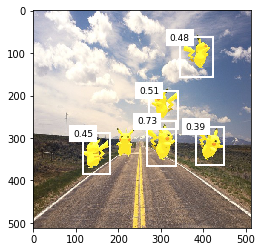

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

img = image.imread('data/pikachu/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)


def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)


#d2l.set_figsize((5, 5))
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0],
                         height=bbox[3]-bbox[1], fill=False, edgecolor=color,linewidth=2)

def _make_list(obj, default_values=None):
    if obj is None:
        obj = default_values
    elif not isinstance(obj, (list, tuple)):
        obj = [obj]
    return obj

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'k'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,bbox=dict(facecolor=color, lw=0))

def display(img, output, threshold):
    fig = plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)